In [22]:

import re
import statistics as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os

!pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

!pip install transformers

from transformers import BertTokenizer, TFBertForSequenceClassification, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.optim import AdamW

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

# Define device
device = 'cuda' if len(tf.config.experimental.list_physical_devices('GPU')) > 0 else 'cpu'
print(f"Using device: {device}")

Num GPUs Available:  1
Using device: cuda


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [23]:
gpus = tf.config.list_physical_devices('GPU')
print("GPUs:", gpus)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [24]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())

2.19.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [25]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mrmorj/hate-speech-and-offensive-language-dataset")

print("Path to dataset files:", path)
print("Files in dataset directory:", os.listdir(path))

Using Colab cache for faster access to the 'hate-speech-and-offensive-language-dataset' dataset.
Path to dataset files: /kaggle/input/hate-speech-and-offensive-language-dataset
Files in dataset directory: ['labeled_data.csv']


In [26]:
from IPython.display import display
data = pd.read_csv(path + '/labeled_data.csv')
print("dataset head:")
display(data.head())
print("dataset info:")
data.info()


dataset head:


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [27]:
data_cleaned = data.drop(columns = ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'])
data_cleaned.rename(columns = {'class':'label'}, inplace=True)

label_mapping = {0: 'hate_speech', 1: 'offensive_language', 2: 'neither'}
data_cleaned['label'] = data_cleaned['label'].map(label_mapping)

print("Cleaned dataset head:")
print(data_cleaned.head())
print("Cleaned dataset info:")
data_cleaned.info()
print("Value counts for labels:")
print(data_cleaned['label'].value_counts())

Cleaned dataset head:
                label                                              tweet
0             neither  !!! RT @mayasolovely: As a woman you shouldn't...
1  offensive_language  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2  offensive_language  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3  offensive_language  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4  offensive_language  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
Cleaned dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   24783 non-null  object
 1   tweet   24783 non-null  object
dtypes: object(2)
memory usage: 387.4+ KB
Value counts for labels:
label
offensive_language    19190
neither                4163
hate_speech            1430
Name: count, dtype: int64


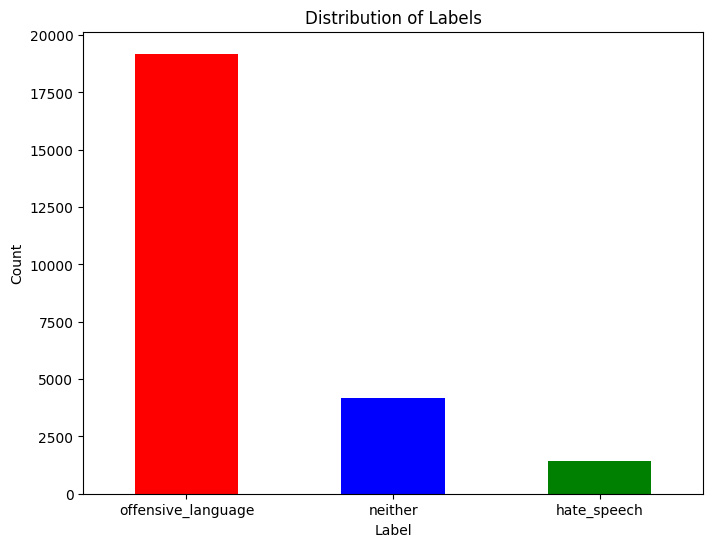

In [28]:
plt.figure(figsize=(8,6))
data_cleaned['label'].value_counts().plot(kind='bar', color = ['red', 'blue', 'green'])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [29]:
stopwords = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = text.lower()  # Lowercase
    tokens = word_tokenize(text)  # Tokenize
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stopwords]  # Remove stopwords and non-alphabetic tokens
    return ' '.join(filtered_tokens)
data_cleaned['tweet'] = data_cleaned['tweet'].apply(clean_text)

print('Data after cleaning:')
print(data_cleaned.head())

Data after cleaning:
                label                                              tweet
0             neither  rt woman complain cleaning house amp man alway...
1  offensive_language  rt boy dats cold tyga dwn bad cuffin dat hoe p...
2  offensive_language  rt dawg rt ever fuck bitch start cry confused ...
3  offensive_language                                rt look like tranny
4  offensive_language  rt shit hear might true might faker bitch told ya


Data after augmentation:
label
offensive_language    19190
hate_speech            5708
neither                4163
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribution of Labels After Augmentation')

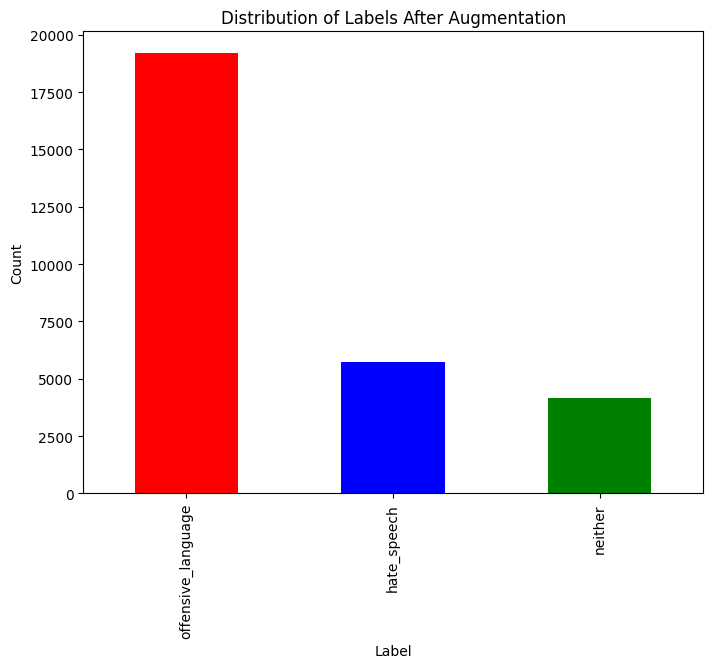

In [30]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ").lower()
            if synonym != word:
                synonyms.add(synonym)
    return list(synonyms)

def augment_text(text, num_augments=1):
    word = text.split()
    augment_text = []
    
    for i in range(num_augments):
        new_words = list(word)
        
        if not new_words:
            continue
        
        random_word_index = np.random.randint(0, len(new_words))
        random_word = new_words[random_word_index]
        
        synonyms = get_synonyms(random_word)
        if synonyms:
            random_synonym = np.random.choice(synonyms)
            new_words[random_word_index] = random_synonym
            
        augment_text.append(' '.join(new_words))
    return augment_text

hate_speech_data = data_cleaned[data_cleaned['label'] == 'hate_speech'].copy()

augment_samples = []
for index, row in hate_speech_data.iterrows():
    augmented_texts  = augment_text(row['tweet'], num_augments=3)
    for aug_text in augmented_texts :
        augment_samples.append({'tweet': aug_text, 'label': 'hate_speech'})
        
agument_df = pd.DataFrame(augment_samples)
data_augmented = pd.concat([data_cleaned, agument_df], ignore_index=True)

print("Data after augmentation:")
print(data_augmented['label'].value_counts())
plt.figure(figsize=(8,6))
data_augmented['label'].value_counts().plot(kind='bar', color = ['red', 'blue', 'green'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels After Augmentation')

Target count for balancing: 19190

Final class distribution:
label
hate_speech           19190
neither               19190
offensive_language    19190
Name: count, dtype: int64


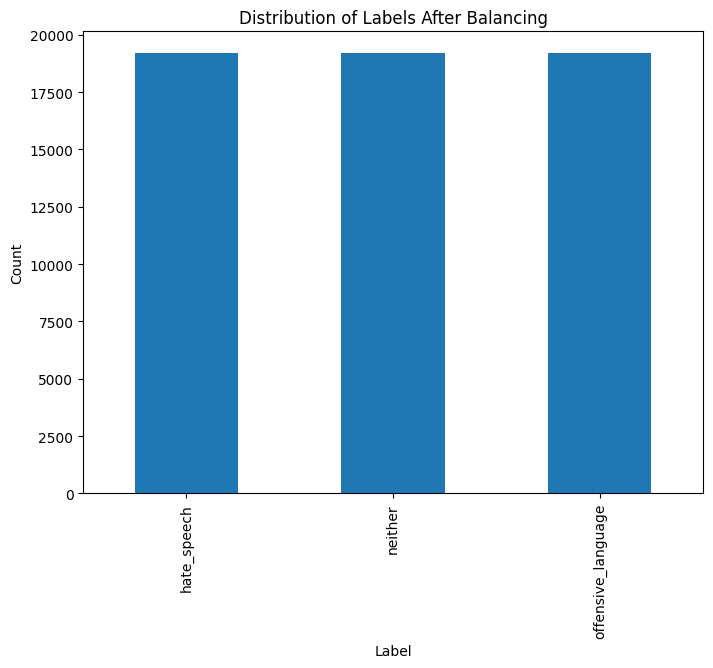

Total samples: 57570
                label                                              tweet
0         hate_speech                        rt got niggas amp got bitch
1             neither                           going free birds anyways
2         hate_speech                            bally royals bitch work
3  offensive_language  twitter say ridin niggah really fuck pull trigger
4  offensive_language  mad cuz fucking ya enemy wins cuz letting shit...


In [31]:
# 1) Tách theo label dạng chuỗi
df_hate   = data_augmented[data_augmented['label'] == 'hate_speech'].copy()
df_off    = data_augmented[data_augmented['label'] == 'offensive_language'].copy()
df_nei    = data_augmented[data_augmented['label'] == 'neither'].copy()

# 2) Target = lớp nhiều nhất
target_count = max(len(df_hate), len(df_off), len(df_nei))
print("Target count for balancing:", target_count)

def augment_to_target(df_class, target):
    # Nếu đã >= target thì downsample về đúng target
    if len(df_class) >= target:
        return df_class.sample(n=target, replace=False, random_state=42)

    # Nếu thiếu thì oversample + augment
    need = target - len(df_class)
    seeds = df_class.sample(n=need, replace=True, random_state=42)

    augmented_rows = []
    for _, row in seeds.iterrows():
        # tạo 1 câu mới
        new_text = augment_text(row['tweet'], num_augments=1)
        new_text = new_text[0] if new_text else row['tweet']  # phòng trường hợp rỗng

        augmented_rows.append({
            'tweet': new_text,
            'label': row['label']
        })

    augmented_df = pd.DataFrame(augmented_rows)
    return pd.concat([df_class, augmented_df], ignore_index=True)

balanced_hate = augment_to_target(df_hate, target_count)
balanced_nei  = augment_to_target(df_nei, target_count)

# 3) Ghép lại dataset cân bằng (giữ offensive nguyên)
data_balanced = pd.concat([df_off, balanced_hate, balanced_nei], ignore_index=True)

# 4) Shuffle
data_balanced = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nFinal class distribution:")
print(data_balanced['label'].value_counts())

plt.figure(figsize=(8,6))
data_balanced['label'].value_counts().plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels After Balancing')
plt.show()

print("Total samples:", len(data_balanced))
print(data_balanced.head())


In [32]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

X_train, X_test, y_train, y_test = train_test_split(
    data_balanced['tweet'].values,
    data_balanced['label'].values,
    test_size=0.2,
    random_state=42,
    stratify=data_balanced['label']
)

y_train_encoded = to_categorical([{'hate_speech':0, 'offensive_language':1, 'neither':2}[label] for label in y_train], num_classes=3)
y_test_encoded = to_categorical([{'hate_speech':0, 'offensive_language':1, 'neither':2}[label] for label in y_test], num_classes=3)
max_seq_length = 128
print("The y train_encoded head: ")
print(y_train_encoded[:5])

The y train_encoded head: 
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [33]:
def tokenize_data(texts, tokenizer, max_length=128):
    enc = tokenizer(
        list(texts),
        add_special_tokens=True,
        truncation=True,
        padding='max_length',      # ✅ đúng cú pháp
        max_length=max_length,
        return_attention_mask=True,
        return_tensors='tf'
    )
    return enc['input_ids'], enc['attention_mask']

# Tokenize
X_train_input_ids, X_train_attention_masks = tokenize_data(X_train, tokenizer, max_seq_length)
X_test_input_ids, X_test_attention_masks = tokenize_data(X_test, tokenizer, max_seq_length)

# tf.data datasets (thêm prefetch để đỡ nghẽn)
train_dataset = tf.data.Dataset.from_tensor_slices(
    ({'input_ids': X_train_input_ids, 'attention_mask': X_train_attention_masks}, y_train_encoded)
).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    ({'input_ids': X_test_input_ids, 'attention_mask': X_test_attention_masks}, y_test_encoded)
).batch(32).prefetch(tf.data.AUTOTUNE)

Test

In [34]:
text = X_train[0]  
print("RAW TEXT:\n", text)

enc = tokenizer(
    text,
    add_special_tokens=True,
    truncation=True,
    padding="max_length",
    max_length=32,              
    return_attention_mask=True,
    return_tensors="tf"
)

input_ids = enc["input_ids"][0].numpy()
attn_mask = enc["attention_mask"][0].numpy()
tokens = tokenizer.convert_ids_to_tokens(input_ids)

print("\nTOKENS:")
print(tokens)

print("\nINPUT_IDS:")
print(input_ids)

print("\nATTENTION_MASK:")
print(attn_mask)

real_tokens = [tok for tok, m in zip(tokens, attn_mask) if m == 1]
print("\nREAL TOKENS (mask=1):")
print(real_tokens)


RAW TEXT:
 heard green tea leaf makes lose weight imma coon explains watermelon

TOKENS:
['[CLS]', 'heard', 'green', 'tea', 'leaf', 'makes', 'lose', 'weight', 'im', '##ma', 'co', '##on', 'explains', 'water', '##mel', '##on', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']

INPUT_IDS:
[  101  2657  2665  5572  7053  3084  4558  3635 10047  2863  2522  2239
  7607  2300 10199  2239   102     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]

ATTENTION_MASK:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

REAL TOKENS (mask=1):
['[CLS]', 'heard', 'green', 'tea', 'leaf', 'makes', 'lose', 'weight', 'im', '##ma', 'co', '##on', 'explains', 'water', '##mel', '##on', '[SEP]']


In [35]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

optimizer = AdamW(model.parameters(), lr=2e-5)

print("Bert Pytorch model loaded successfully.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Bert Pytorch model loaded successfully.


In [36]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# 1) Map label string -> int (0/1/2)
label2id = {'hate_speech': 0, 'offensive_language': 1, 'neither': 2}

def to_label_ids(labels):
    # labels có thể là list/np array/pandas series
    labels = np.asarray(labels)
    # nếu labels là string/object -> map
    if labels.dtype == object or isinstance(labels[0], str):
        labels = np.array([label2id[x] for x in labels], dtype=np.int64)
    else:
        labels = labels.astype(np.int64)
    return labels

y_train_ids = to_label_ids(y_train)
y_test_ids  = to_label_ids(y_test)

print("y_train example:", y_train[:5])
print("y_train_ids example:", y_train_ids[:5], "dtype:", y_train_ids.dtype)

# 2) Tokenize (batch, nhanh)
def prepare_data(texts, labels_ids, tokenizer, max_length=128):
    enc = tokenizer(
        list(texts),
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids = enc['input_ids']
    attention_masks = enc['attention_mask']
    labels_tensor = torch.tensor(labels_ids, dtype=torch.long)
    return input_ids, attention_masks, labels_tensor

train_input_ids, train_attention_masks, train_labels = prepare_data(X_train, y_train_ids, tokenizer, max_length=128)
test_input_ids, test_attention_masks, test_labels = prepare_data(X_test, y_test_ids, tokenizer, max_length=128)

# 3) DataLoader
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
test_dataset  = TensorDataset(test_input_ids, test_attention_masks, test_labels)

batch_size = 32
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
validation_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

print("DataLoaders prepared.")
print("Train batch shapes (input_ids, mask, labels):",
      next(iter(train_dataloader))[0].shape,
      next(iter(train_dataloader))[1].shape,
      next(iter(train_dataloader))[2].shape)


y_train example: ['neither' 'neither' 'neither' 'neither' 'neither']
y_train_ids example: [2 2 2 2 2] dtype: int64
DataLoaders prepared.
Train batch shapes (input_ids, mask, labels): torch.Size([32, 128]) torch.Size([32, 128]) torch.Size([32])


In [37]:
from google.colab import files

In [38]:
# =========================
# TRAIN + EARLY STOPPING + SAVE BEST MODEL (into a repo folder)
# - Saves BOTH: (1) HuggingFace folder (recommended) and (2) state_dict .pt
# - You can open repo folder and see: checkpoints/bert_best/  and checkpoints/best_model.pt
# =========================

import os
import numpy as np
import torch
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm.notebook import tqdm

# --------- 0) Where will it save? (relative to current working directory) ----------
print("Current working dir:", os.getcwd())

SAVE_DIR = "checkpoints"  # folder in your repo (or current folder)
os.makedirs(SAVE_DIR, exist_ok=True)

BEST_PT_PATH = os.path.join(SAVE_DIR, "best_model.pt")     # state_dict
BEST_HF_DIR  = os.path.join(SAVE_DIR, "bert_best")         # HF format folder
os.makedirs(BEST_HF_DIR, exist_ok=True)

# --------- 1) Device ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

# --------- 2) Training params ----------
epochs = 10
patience = 3
best_val_loss = float("inf")
patience_counter = 0

optimizer = AdamW(model.parameters(), lr=3e-5)

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

train_losses, val_losses, val_accuracies = [], [], []

# --------- 3) Training loop ----------
for epoch_i in range(epochs):
    print(f"\n======== Epoch {epoch_i + 1} / {epochs} ========")

    # ---- Train ----
    model.train()
    total_train_loss = 0.0

    for step, batch in enumerate(tqdm(train_dataloader, desc="Training", leave=False)):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad(set_to_none=True)

        outputs = model(
            input_ids=b_input_ids,
            attention_mask=b_input_mask,
            labels=b_labels
        )
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        if step % 50 == 0 and step != 0:
            print(f"  Step {step}/{len(train_dataloader)} | avg loss so far: {total_train_loss/(step+1):.4f}")

    avg_train_loss = total_train_loss / max(1, len(train_dataloader))
    train_losses.append(avg_train_loss)
    print(f"Average training loss: {avg_train_loss:.4f}")

    # ---- Validate ----
    model.eval()
    total_eval_loss = 0.0
    total_eval_accuracy = 0.0

    for batch in tqdm(validation_dataloader, desc="Validation", leave=False):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(
                input_ids=b_input_ids,
                attention_mask=b_input_mask,
                labels=b_labels
            )

        loss = outputs.loss
        logits = outputs.logits

        total_eval_loss += loss.item()

        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
        labels = b_labels.detach().cpu().numpy()
        batch_acc = (preds == labels).mean()
        total_eval_accuracy += batch_acc

    avg_val_loss = total_eval_loss / max(1, len(validation_dataloader))
    avg_val_acc = total_eval_accuracy / max(1, len(validation_dataloader))

    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)

    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Acc : {avg_val_acc:.4f}")

    # ---- Early stopping + Save best ----
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0

        # (A) Save HuggingFace folder (recommended)
        model.save_pretrained(BEST_HF_DIR)
        tokenizer.save_pretrained(BEST_HF_DIR)

        # (B) Save state_dict too (optional)
        torch.save(model.state_dict(), BEST_PT_PATH)

        print(f"✅ Improved! Saved to:\n - {BEST_HF_DIR}\n - {BEST_PT_PATH}")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("🛑 Early stopping triggered.")
            break

print("\nTraining complete!")
print("Best val loss:", best_val_loss)
# Zip folder checkpoints rồi tải về máy
!zip -r checkpoints.zip checkpoints

files.download("checkpoints.zip")



Current working dir: /content
Using device: cuda

======== Epoch 1 / 10 ========


Training:   0%|          | 0/1440 [00:00<?, ?it/s]

  Step 50/1440 | avg loss so far: 0.8768
  Step 100/1440 | avg loss so far: 0.7582
  Step 150/1440 | avg loss so far: 0.6966
  Step 200/1440 | avg loss so far: 0.6545
  Step 250/1440 | avg loss so far: 0.6192
  Step 300/1440 | avg loss so far: 0.5991
  Step 350/1440 | avg loss so far: 0.5770
  Step 400/1440 | avg loss so far: 0.5560
  Step 450/1440 | avg loss so far: 0.5418
  Step 500/1440 | avg loss so far: 0.5252
  Step 550/1440 | avg loss so far: 0.5137
  Step 600/1440 | avg loss so far: 0.5019
  Step 650/1440 | avg loss so far: 0.4921
  Step 700/1440 | avg loss so far: 0.4850
  Step 750/1440 | avg loss so far: 0.4752
  Step 800/1440 | avg loss so far: 0.4669
  Step 850/1440 | avg loss so far: 0.4592
  Step 900/1440 | avg loss so far: 0.4488
  Step 950/1440 | avg loss so far: 0.4417
  Step 1000/1440 | avg loss so far: 0.4340
  Step 1050/1440 | avg loss so far: 0.4268
  Step 1100/1440 | avg loss so far: 0.4194
  Step 1150/1440 | avg loss so far: 0.4139
  Step 1200/1440 | avg loss so 

Validation:   0%|          | 0/360 [00:00<?, ?it/s]

Validation Loss: 0.2259
Validation Acc : 0.9232
✅ Improved! Saved to:
 - checkpoints/bert_best
 - checkpoints/best_model.pt

======== Epoch 2 / 10 ========


Training:   0%|          | 0/1440 [00:00<?, ?it/s]

  Step 50/1440 | avg loss so far: 0.1607
  Step 100/1440 | avg loss so far: 0.1530
  Step 150/1440 | avg loss so far: 0.1587
  Step 200/1440 | avg loss so far: 0.1630
  Step 250/1440 | avg loss so far: 0.1625
  Step 300/1440 | avg loss so far: 0.1676
  Step 350/1440 | avg loss so far: 0.1682
  Step 400/1440 | avg loss so far: 0.1702
  Step 450/1440 | avg loss so far: 0.1704
  Step 500/1440 | avg loss so far: 0.1712
  Step 550/1440 | avg loss so far: 0.1689
  Step 600/1440 | avg loss so far: 0.1689
  Step 650/1440 | avg loss so far: 0.1680
  Step 700/1440 | avg loss so far: 0.1682
  Step 750/1440 | avg loss so far: 0.1668
  Step 800/1440 | avg loss so far: 0.1655
  Step 850/1440 | avg loss so far: 0.1638
  Step 900/1440 | avg loss so far: 0.1619
  Step 950/1440 | avg loss so far: 0.1605
  Step 1000/1440 | avg loss so far: 0.1595
  Step 1050/1440 | avg loss so far: 0.1578
  Step 1100/1440 | avg loss so far: 0.1574
  Step 1150/1440 | avg loss so far: 0.1561
  Step 1200/1440 | avg loss so 

Validation:   0%|          | 0/360 [00:00<?, ?it/s]

Validation Loss: 0.1587
Validation Acc : 0.9500
✅ Improved! Saved to:
 - checkpoints/bert_best
 - checkpoints/best_model.pt

======== Epoch 3 / 10 ========


Training:   0%|          | 0/1440 [00:00<?, ?it/s]

  Step 50/1440 | avg loss so far: 0.0832
  Step 100/1440 | avg loss so far: 0.0889
  Step 150/1440 | avg loss so far: 0.0847
  Step 200/1440 | avg loss so far: 0.0823
  Step 250/1440 | avg loss so far: 0.0876
  Step 300/1440 | avg loss so far: 0.0867
  Step 350/1440 | avg loss so far: 0.0856
  Step 400/1440 | avg loss so far: 0.0845
  Step 450/1440 | avg loss so far: 0.0821
  Step 500/1440 | avg loss so far: 0.0837
  Step 550/1440 | avg loss so far: 0.0850
  Step 600/1440 | avg loss so far: 0.0843
  Step 650/1440 | avg loss so far: 0.0862
  Step 700/1440 | avg loss so far: 0.0881
  Step 750/1440 | avg loss so far: 0.0860
  Step 800/1440 | avg loss so far: 0.0873
  Step 850/1440 | avg loss so far: 0.0862
  Step 900/1440 | avg loss so far: 0.0860
  Step 950/1440 | avg loss so far: 0.0856
  Step 1000/1440 | avg loss so far: 0.0855
  Step 1050/1440 | avg loss so far: 0.0858
  Step 1100/1440 | avg loss so far: 0.0873
  Step 1150/1440 | avg loss so far: 0.0871
  Step 1200/1440 | avg loss so 

Validation:   0%|          | 0/360 [00:00<?, ?it/s]

Validation Loss: 0.1603
Validation Acc : 0.9609
No improvement. Patience: 1/3

======== Epoch 4 / 10 ========


Training:   0%|          | 0/1440 [00:00<?, ?it/s]

  Step 50/1440 | avg loss so far: 0.0475
  Step 100/1440 | avg loss so far: 0.0424
  Step 150/1440 | avg loss so far: 0.0454
  Step 200/1440 | avg loss so far: 0.0502
  Step 250/1440 | avg loss so far: 0.0535
  Step 300/1440 | avg loss so far: 0.0541
  Step 350/1440 | avg loss so far: 0.0540
  Step 400/1440 | avg loss so far: 0.0539
  Step 450/1440 | avg loss so far: 0.0546
  Step 500/1440 | avg loss so far: 0.0538
  Step 550/1440 | avg loss so far: 0.0531
  Step 600/1440 | avg loss so far: 0.0512
  Step 650/1440 | avg loss so far: 0.0513
  Step 700/1440 | avg loss so far: 0.0539
  Step 750/1440 | avg loss so far: 0.0542
  Step 800/1440 | avg loss so far: 0.0532
  Step 850/1440 | avg loss so far: 0.0527
  Step 900/1440 | avg loss so far: 0.0519
  Step 950/1440 | avg loss so far: 0.0516
  Step 1000/1440 | avg loss so far: 0.0527
  Step 1050/1440 | avg loss so far: 0.0527
  Step 1100/1440 | avg loss so far: 0.0526
  Step 1150/1440 | avg loss so far: 0.0522
  Step 1200/1440 | avg loss so 

Validation:   0%|          | 0/360 [00:00<?, ?it/s]

Validation Loss: 0.1780
Validation Acc : 0.9631
No improvement. Patience: 2/3

======== Epoch 5 / 10 ========


Training:   0%|          | 0/1440 [00:00<?, ?it/s]

  Step 50/1440 | avg loss so far: 0.0323
  Step 100/1440 | avg loss so far: 0.0369
  Step 150/1440 | avg loss so far: 0.0320
  Step 200/1440 | avg loss so far: 0.0319
  Step 250/1440 | avg loss so far: 0.0341
  Step 300/1440 | avg loss so far: 0.0331
  Step 350/1440 | avg loss so far: 0.0327
  Step 400/1440 | avg loss so far: 0.0333
  Step 450/1440 | avg loss so far: 0.0320
  Step 500/1440 | avg loss so far: 0.0322
  Step 550/1440 | avg loss so far: 0.0316
  Step 600/1440 | avg loss so far: 0.0328
  Step 650/1440 | avg loss so far: 0.0312
  Step 700/1440 | avg loss so far: 0.0315
  Step 750/1440 | avg loss so far: 0.0313
  Step 800/1440 | avg loss so far: 0.0304
  Step 850/1440 | avg loss so far: 0.0302
  Step 900/1440 | avg loss so far: 0.0314
  Step 950/1440 | avg loss so far: 0.0327
  Step 1000/1440 | avg loss so far: 0.0330
  Step 1050/1440 | avg loss so far: 0.0332
  Step 1100/1440 | avg loss so far: 0.0344
  Step 1150/1440 | avg loss so far: 0.0340
  Step 1200/1440 | avg loss so 

Validation:   0%|          | 0/360 [00:00<?, ?it/s]

Validation Loss: 0.1977
Validation Acc : 0.9638
No improvement. Patience: 3/3
🛑 Early stopping triggered.

Training complete!
Best val loss: 0.15869135135370824
  adding: checkpoints/ (stored 0%)
  adding: checkpoints/bert_best/ (stored 0%)
  adding: checkpoints/bert_best/special_tokens_map.json (deflated 42%)
  adding: checkpoints/bert_best/tokenizer_config.json (deflated 75%)
  adding: checkpoints/bert_best/config.json (deflated 51%)
  adding: checkpoints/bert_best/vocab.txt (deflated 53%)
  adding: checkpoints/bert_best/model.safetensors (deflated 7%)
  adding: checkpoints/best_model.pt (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

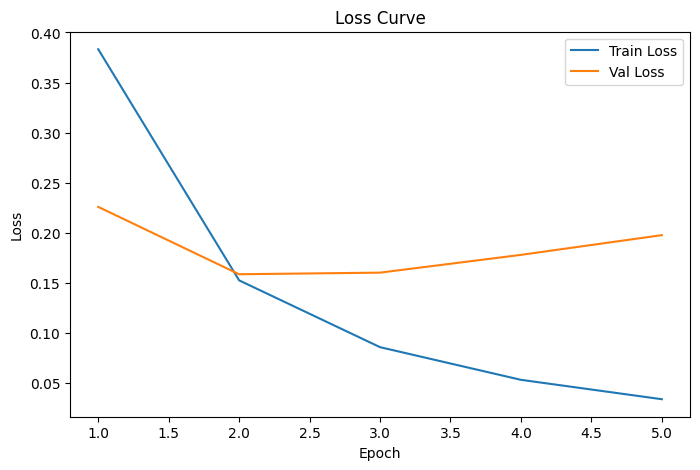

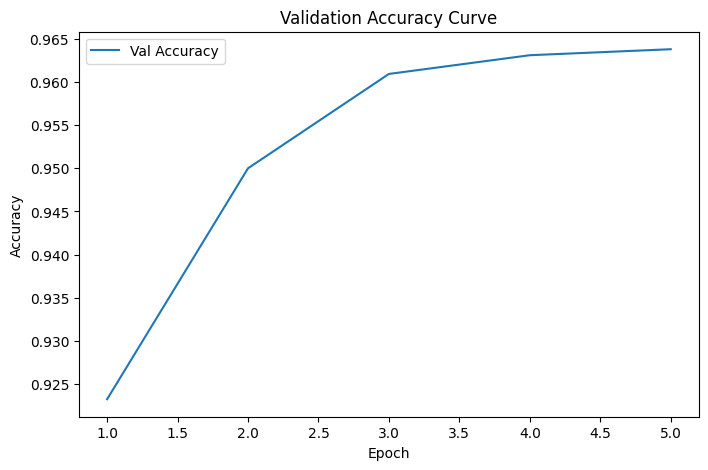

In [39]:
import matplotlib.pyplot as plt

# train_losses, val_losses, val_accuracies phải là list theo epoch
epochs_ran = range(1, len(train_losses) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs_ran, train_losses, label="Train Loss")
plt.plot(epochs_ran, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs_ran, val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Curve")
plt.legend()
plt.show()


In [40]:
import torch

BEST_PT_PATH = "checkpoints/best_model.pt"  # đổi đúng path bạn lưu

model.load_state_dict(torch.load(BEST_PT_PATH, map_location=device))
model.to(device)
model.eval()

print("Loaded best model from:", BEST_PT_PATH)


Loaded best model from: checkpoints/best_model.pt


In [41]:
from transformers import BertForSequenceClassification

MODEL_DIR = "checkpoints/bert_best"
model = BertForSequenceClassification.from_pretrained(MODEL_DIR).to(device)
model.eval()
print("Loaded HF model from:", MODEL_DIR)


Loaded HF model from: checkpoints/bert_best


                    precision    recall  f1-score   support

       hate_speech     0.9592    0.9362    0.9475      3838
offensive_language     0.9287    0.9406    0.9346      3838
           neither     0.9624    0.9732    0.9677      3838

          accuracy                         0.9500     11514
         macro avg     0.9501    0.9500    0.9500     11514
      weighted avg     0.9501    0.9500    0.9500     11514



<Figure size 600x600 with 0 Axes>

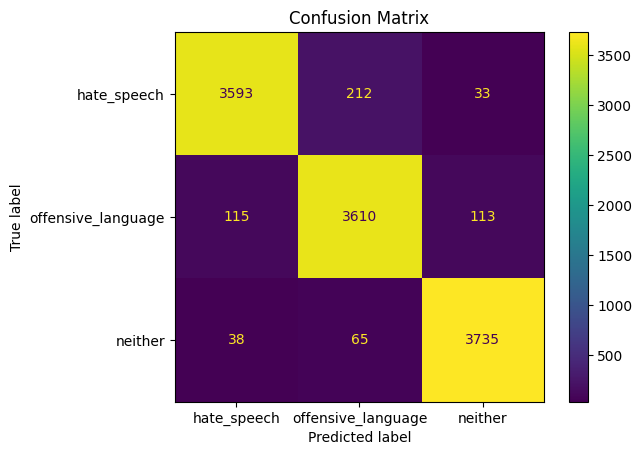

In [42]:
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# map id -> label (phải đúng với label2id bạn dùng khi train)
id2label = {0: "hate_speech", 1: "offensive_language", 2: "neither"}

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        outputs = model(
            input_ids=b_input_ids,
            attention_mask=b_input_mask
        )
        logits = outputs.logits

        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(b_labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# ---- Classification report ----
target_names = [id2label[i] for i in sorted(id2label.keys())]
print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))

# ---- Confusion matrix ----
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

plt.figure(figsize=(6, 6))
disp.plot(values_format="d")
plt.title("Confusion Matrix")
plt.show()


In [50]:
!zip -r checkpoints.zip checkpoints

files.download("checkpoints.zip")


updating: checkpoints/ (stored 0%)
updating: checkpoints/bert_best/ (stored 0%)
updating: checkpoints/bert_best/special_tokens_map.json (deflated 42%)
updating: checkpoints/bert_best/tokenizer_config.json (deflated 75%)
updating: checkpoints/bert_best/config.json (deflated 51%)
updating: checkpoints/bert_best/vocab.txt (deflated 53%)
updating: checkpoints/bert_best/model.safetensors (deflated 7%)
updating: checkpoints/best_model.pt (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os

print("Current working dir:", os.getcwd())
print("Files here:", os.listdir("."))

print("checkpoints.zip exists?", os.path.exists("checkpoints.zip"))
print("checkpoints exists?", os.path.exists("checkpoints"))


Current working dir: /content
Files here: ['.config', 'checkpoints', 'checkpoints.zip', 'sample_data']
checkpoints.zip exists? True
checkpoints exists? True


In [52]:
from google.colab import files
import shutil

# Nén thư mục
shutil.make_archive('checkpoints', 'zip', 'checkpoints')

# Lệnh tải file về máy
files.download('checkpoints.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
print(os.path.abspath("checkpoints.zip"))

/content/checkpoints.zip
